In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_hastie_10_2
import matplotlib.pyplot as plt

In [2]:
# Read data
x, y = make_hastie_10_2()
df = pd.DataFrame(x)
df['Y'] = y
df['Y']

0        1.0
1       -1.0
2       -1.0
3       -1.0
4       -1.0
        ... 
11995    1.0
11996    1.0
11997   -1.0
11998    1.0
11999    1.0
Name: Y, Length: 12000, dtype: float64

In [3]:
# Split into training and test set
train, test = train_test_split(df, test_size = 0.2)
X_train, Y_train = train.ix[:,:-1], train.ix[:,-1]
X_test, Y_test = test.ix[:,:-1], test.ix[:,-1]

/home/msc2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/home/msc2/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
/home/msc2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/

In [4]:
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

In [5]:
def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

In [6]:
# Fit a simple decision tree first
clf_tree = DecisionTreeClassifier(max_depth = 1, random_state = 1)
er_tree = generic_clf(Y_train, X_train, Y_test, X_test, clf_tree)
er_tree

(0.44364583333333335, 0.465)

In [7]:
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    # Initialize weights
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):
        # Fit a classifier with the specific weights
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        # Indicator function
        miss = [int(x) for x in (pred_train_i != Y_train)]
        # Equivalent with 1/-1 to update weights
        miss2 = [x if x==1 else -1 for x in miss]
        # Error
        err_m = np.dot(w,miss) / sum(w)
        # Alpha
        alpha_m = 0.5 * np.log( (1 - err_m) / float(err_m))
        # New weights
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
        # Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, 
                                          [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, 
                                         [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    # Return error rate in train and test set
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

In [8]:
# Fit Adaboost classifier using a decision tree as base estimator
# Test with different number of iterations
er_train, er_test = [er_tree[0]], [er_tree[1]]
x_range = range(10, 410, 10)
for i in x_range:    
    er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
    er_train.append(er_i[0])
    er_test.append(er_i[1])

In [9]:
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')

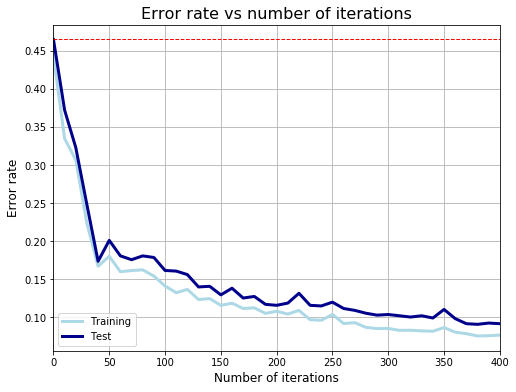

In [10]:
# Compare error rate vs number of iterations
plot_error_rate(er_train, er_test)